In [0]:
%%time 
!apt update
!apt upgrade
# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes

In [0]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [0]:
# !pip install pygsheets
# !pip install --upgrade -q pygsheets
# !pip install clean-text[gpl]
# !pip install geopandas

In [0]:
# # import the necessary library
# import pandas as pd
# import geopandas as gpd
# from shapely import wkt
# import numpy as np 
# import os
# import ast

# from datetime import datetime
# import re
# import string
# from pprint import pprint
# from cleantext import clean

# import seaborn as sns
# import matplotlib.pyplot as plt

# import pygsheets

# import warnings
# warnings.filterwarnings("ignore")

## Vaud District Boundaries

In [0]:
gdf_vaud = gpd.read_file('http://cultureincities.com/sport/data/geometry_district.geojson')

In [57]:
gdf_vaud.head(5)

,OBJECTID,SHAPE_AREA,SHAPE_LEN,NO_CANTON,NOM_MIN,NOM_MAJ,NO_DIS_FED,NO_COM_FED,NO_COM_CAN,NO_DIS_CAN,geometry
0,29,6.630607e+06,15714.267327,22,Vulliens,VULLIENS,2222,5803,302,2,"POLYGON ((6.79833 46.59986, 6.79378 46.59899, ..."
1,30,9.522108e+06,16730.407119,22,Yens,YENS,2227,5655,188,7,"POLYGON ((6.41568 46.50994, 6.41166 46.51123, ..."
2,31,1.325455e+07,21991.403627,22,Echichens,ECHICHENS,2227,5634,167,7,"POLYGON ((6.48101 46.52333, 6.48046 46.52394, ..."
3,32,2.904487e+06,8368.067727,22,Coinsins,COINSINS,2228,5710,231,8,"POLYGON ((6.25078 46.41559, 6.24994 46.41530, ..."
4,33,1.018120e+07,18942.417911,22,Grandcour,GRANDCOUR,2222,5817,309,2,"POLYGON ((6.91080 46.88062, 6.91791 46.88414, ..."


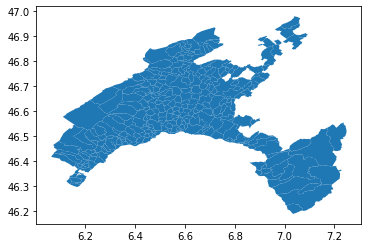

In [58]:
gdf_vaud.plot()

## Airbnb Data

In [59]:
airbnb = pd.read_csv('http://cultureincities.com/sport/data/airbnb/airbnb_vaud_january_since2016.csv')
airbnb.drop(columns={'Unnamed: 0'}, inplace=True)
airbnb.head()

,listing_id,id,review_date,reviewer_id,reviewer_name,comments,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,review_year,review_month,review_day
0,26809,60024638,2016-01-18,37911239,Jeremy,"Appartement très propre, calme et bien situé d...","Quiet bedroom, private bathroom",94917,Eric,Lavaux-Oron,Pully,46.52228,6.66425,Private room,70,2016,1,18
1,26809,60359278,2016-01-22,45132344,Luigina,I spent recently two days by Eric's home and i...,"Quiet bedroom, private bathroom",94917,Eric,Lavaux-Oron,Pully,46.52228,6.66425,Private room,70,2016,1,22
2,26809,60899288,2016-01-29,51714467,Pascale,Éric est un hôte chaleureux et arrangeant.\r\n...,"Quiet bedroom, private bathroom",94917,Eric,Lavaux-Oron,Pully,46.52228,6.66425,Private room,70,2016,1,29
3,26809,128022235,2017-01-22,18549056,Manoug,Excellent comme les fois précédentes.,"Quiet bedroom, private bathroom",94917,Eric,Lavaux-Oron,Pully,46.52228,6.66425,Private room,70,2017,1,22
4,233016,586681124,2020-01-02,307241152,Antonio,We enjoyed the place. Thank you!,Your little piece of Paradise!,1219574,Michael,Aigle,Ormont-Dessus,46.34960,7.16248,Entire home/apt,125,2020,1,2


In [0]:
# Transform the pandas df file into a geopandas df (Geometry from point polygon!)
airbnb_geo = gpd.GeoDataFrame(airbnb, geometry=gpd.points_from_xy(airbnb.longitude, airbnb.latitude))

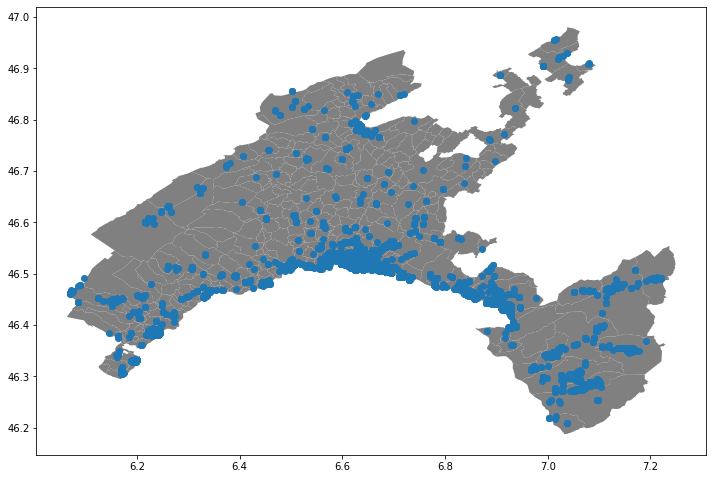

In [61]:
fig, ax = plt.subplots(figsize=(12,10))
gdf_vaud.plot(color="Gray", ax= ax);
airbnb_geo.plot(ax=ax);

In [0]:
gdf_vaud.crs = 'EPSG:4326'
airbnb_geo.crs = 'EPSG:4326'

In [63]:
gdf_vaud.crs == airbnb_geo.crs

True

In [64]:
airbnb_geo.head(2)

,listing_id,id,review_date,reviewer_id,reviewer_name,comments,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,review_year,review_month,review_day,geometry
0,26809,60024638,2016-01-18,37911239,Jeremy,"Appartement très propre, calme et bien situé d...","Quiet bedroom, private bathroom",94917,Eric,Lavaux-Oron,Pully,46.52228,6.66425,Private room,70,2016,1,18,POINT (6.66425 46.52228)
1,26809,60359278,2016-01-22,45132344,Luigina,I spent recently two days by Eric's home and i...,"Quiet bedroom, private bathroom",94917,Eric,Lavaux-Oron,Pully,46.52228,6.66425,Private room,70,2016,1,22,POINT (6.66425 46.52228)


In [65]:
gdf_vaud.head(2)

,OBJECTID,SHAPE_AREA,SHAPE_LEN,NO_CANTON,NOM_MIN,NOM_MAJ,NO_DIS_FED,NO_COM_FED,NO_COM_CAN,NO_DIS_CAN,geometry
0,29,6.630607e+06,15714.267327,22,Vulliens,VULLIENS,2222,5803,302,2,"POLYGON ((6.79833 46.59986, 6.79378 46.59899, ..."
1,30,9.522108e+06,16730.407119,22,Yens,YENS,2227,5655,188,7,"POLYGON ((6.41568 46.50994, 6.41166 46.51123, ..."


### Spatial join

In [66]:
sjoined_listings = gpd.sjoin(gdf_vaud, airbnb_geo, op="contains")
sjoined_listings.head()

,OBJECTID,SHAPE_AREA,SHAPE_LEN,NO_CANTON,NOM_MIN,NOM_MAJ,NO_DIS_FED,NO_COM_FED,NO_COM_CAN,NO_DIS_CAN,geometry,index_right,listing_id,id,review_date,reviewer_id,reviewer_name,comments,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,review_year,review_month,review_day
1,30,9.522108e+06,16730.407119,22,Yens,YENS,2227,5655,188,7,"POLYGON ((6.41568 46.50994, 6.41166 46.51123, ...",185,2436952,129081833,2017-01-29,14152607,Filipe,"Maurice is an amazing Host, very helpful Perso...",CONFORT - VIEW - GOOD PRICE 6 ROOMS - 2/7 GUESTS,12455032,Maurice,Morges,Yens,46.51809,6.41755,Entire home/apt,99,2017,1,29
2,31,1.325455e+07,21991.403627,22,Echichens,ECHICHENS,2227,5634,167,7,"POLYGON ((6.48101 46.52333, 6.48046 46.52394, ...",510,5108203,367152179,2019-01-04,55083813,Pierre,LA PETITE MAISON est jolie et magnifiquement s...,La Petite Maison,26302035,Huguette,Morges,Echichens,46.52850,6.50179,Entire home/apt,113,2019,1,4
2,31,1.325455e+07,21991.403627,22,Echichens,ECHICHENS,2227,5634,167,7,"POLYGON ((6.48101 46.52333, 6.48046 46.52394, ...",1791,15502391,125730978,2017-01-07,79421272,Francois,The host canceled this reservation 15 days bef...,Appartement charmant sur Léman,69219491,Alain,Morges,Echichens,46.52654,6.49818,Entire home/apt,95,2017,1,7
2,31,1.325455e+07,21991.403627,22,Echichens,ECHICHENS,2227,5634,167,7,"POLYGON ((6.48101 46.52333, 6.48046 46.52394, ...",1730,15177381,599863257,2020-01-31,260249457,Nicolas,"Studio très bien équipé, très bien situé, calm...",Studio spacieux et confortable,26302035,Huguette,Morges,Echichens,46.52682,6.50258,Entire home/apt,65,2020,1,31
2,31,1.325455e+07,21991.403627,22,Echichens,ECHICHENS,2227,5634,167,7,"POLYGON ((6.48101 46.52333, 6.48046 46.52394, ...",1729,15177381,128735679,2017-01-27,98968559,Julien,"Très bon accueil, joli lieu et très belle vue ...",Studio spacieux et confortable,26302035,Huguette,Morges,Echichens,46.52682,6.50258,Entire home/apt,65,2017,1,27


In [116]:
x = sjoined_listings.groupby(['neighbourhood', 'review_month', 'review_year']).\
    apply(lambda x: pd.Series(x.price.count(),index=['price'])).unstack()

x.columns = x.columns.get_level_values(1)
x.reset_index(inplace=True)
x.dropna(inplace=True)
x.head()

review_year,neighbourhood,review_month,2016,2017,2018,2019,2020
1,Aigle,1,4.0,6.0,3.0,8.0,13.0
11,Bex,1,3.0,1.0,6.0,4.0,26.0
17,Bourg-en-Lavaux,1,1.0,11.0,12.0,18.0,25.0
25,Chardonne,1,1.0,9.0,4.0,3.0,10.0
28,Chavannes-près-Renens,1,2.0,7.0,17.0,10.0,20.0


In [113]:
x.columns

Index(['neighbourhood', 'review_month', 2016, 2017, 2018, 2019, 2020], dtype='object', name='review_year')

In [0]:
x['demand_change'] = 100*(x[2020]/x[2019])

In [126]:
x = x.loc[:, ['neighbourhood', 'demand_change']]
# x.reset_index(inplace=True)
# x.drop(columns={'review_year'}, inplace=True)
x.head()

review_year,neighbourhood,demand_change
0,Aigle,162.500000
1,Bex,650.000000
2,Bourg-en-Lavaux,138.888889
3,Chardonne,333.333333
4,Chavannes-près-Renens,200.000000


In [88]:
grouped = sjoined_listings.groupby("neighbourhood").size()
df = grouped.to_frame().reset_index()
df.columns = ['neighbourhood', 'listings_count']
df.head()

,neighbourhood,listings_count
0,Aclens,2
1,Aigle,34
2,Allaman,1
3,Apples,1
4,Arzier-Le Muids,10


In [89]:
df.shape

(178, 2)

In [76]:
df[df.neighbourhood == 'Coinsins']

,neighbourhood,listings_count


In [0]:
gdf_vaud.columns = ['OBJECTID', 'SHAPE_AREA', 'SHAPE_LEN', 'NO_CANTON', 'neighbourhood',
       'NOM_MAJ', 'NO_DIS_FED', 'NO_COM_FED', 'NO_COM_CAN', 'NO_DIS_CAN',
       'geometry']

In [129]:
airbnb_merged = gdf_vaud.merge(x, on='neighbourhood', how='outer')
airbnb_merged.head()

,OBJECTID,SHAPE_AREA,SHAPE_LEN,NO_CANTON,neighbourhood,NOM_MAJ,NO_DIS_FED,NO_COM_FED,NO_COM_CAN,NO_DIS_CAN,geometry,demand_change
0,29.0,6.630607e+06,15714.267327,22.0,Vulliens,VULLIENS,2222.0,5803.0,302.0,2.0,"POLYGON ((6.79833 46.59986, 6.79378 46.59899, ...",NaN
1,30.0,9.522108e+06,16730.407119,22.0,Yens,YENS,2227.0,5655.0,188.0,7.0,"POLYGON ((6.41568 46.50994, 6.41166 46.51123, ...",NaN
2,31.0,1.325455e+07,21991.403627,22.0,Echichens,ECHICHENS,2227.0,5634.0,167.0,7.0,"POLYGON ((6.48101 46.52333, 6.48046 46.52394, ...",NaN
3,32.0,2.904487e+06,8368.067727,22.0,Coinsins,COINSINS,2228.0,5710.0,231.0,8.0,"POLYGON ((6.25078 46.41559, 6.24994 46.41530, ...",NaN
4,33.0,1.018120e+07,18942.417911,22.0,Grandcour,GRANDCOUR,2222.0,5817.0,309.0,2.0,"POLYGON ((6.91080 46.88062, 6.91791 46.88414, ...",NaN


In [131]:
airbnb_merged.sort_values(by='demand_change', ascending=False)[:5]

,OBJECTID,SHAPE_AREA,SHAPE_LEN,NO_CANTON,neighbourhood,NOM_MAJ,NO_DIS_FED,NO_COM_FED,NO_COM_CAN,NO_DIS_CAN,geometry,demand_change
309,NaN,NaN,NaN,NaN,Renens (Vaud),NaN,NaN,NaN,NaN,NaN,None,783.333333
127,114.0,9.658051e+07,55455.388370,22.0,Bex,BEX,2221.0,5402.0,2.0,1.0,"POLYGON ((7.00814 46.22005, 7.00723 46.22148, ...",650.000000
11,40.0,2.095660e+07,29295.800606,22.0,Vully-les-Lacs,VULLY-LES-LACS,2222.0,5464.0,34.0,2.0,"POLYGON ((6.98427 46.94078, 6.98763 46.93750, ...",600.000000
26,55.0,8.319349e+06,15673.784200,22.0,Gland,GLAND,2228.0,5721.0,242.0,8.0,"POLYGON ((6.27891 46.42953, 6.28152 46.42838, ...",450.000000
267,278.0,1.350194e+07,24950.294243,22.0,Yverdon-les-Bains,YVERDON-LES-BAINS,2224.0,5938.0,387.0,4.0,"POLYGON ((6.65095 46.75674, 6.65059 46.75630, ...",433.333333


In [132]:
airbnb_merged.shape[0] == airbnb.shape[0]

False

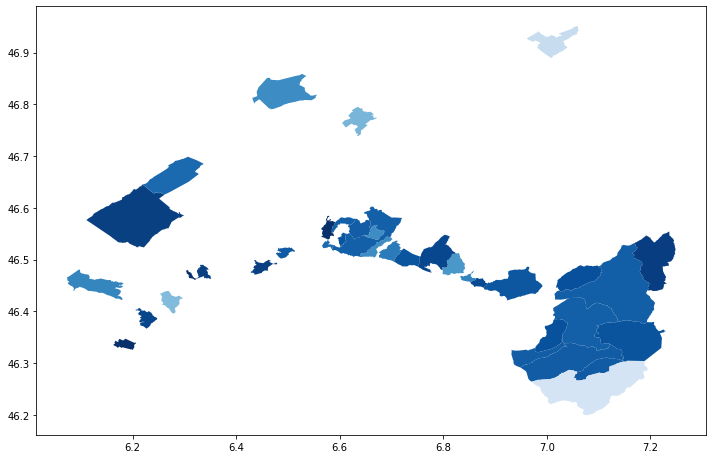

In [137]:
airbnb_merged.plot(column="demand_change", cmap="Blues_r", figsize=(12,10))

## Instagram Data